# Instructions

As in the previous assignment, youl'll be using PyTorch instead of EDF. This assignment will focus on generative modelling, and you'll implement and train a VAE and a GAN.

It is highly suggested to use google colab and run the notebook on a GPU node.
Check https://colab.research.google.com/ and look for tutorials online on how to use it. To use a GPU go to Runtime -> Change runtime type and select GPU.

In [ ]:
import torch, math, copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from scipy.stats import kde
import matplotlib.pyplot as plt

We'll start by coding up a toy problem and seeing how a VAE and a GAN behave on it. Consider the following stochastic process:
$$ \mu_x \sim U(\{1,2,3\})$$
$$ \mu_y \sim U(\{1,2,3\})$$
$$ s \sim \mathcal N \left([\mu_x, \mu_y], \frac{1}{100}I \right)$$
where $I$ is the $2 \times 2$ identity matrix.

Implement the function in the next cell such that it returns $n$ samples distributed as $s$ from the above process. The returned object should be a $n \times 2$ PyTorch tensor.

In [ ]:
def sample(n):

    # draw means of x and y such that these means range uniformly from 1 to 3
    mu_x = torch.randint(1, 4, (n,))
    mu_y = torch.randint(1, 4, (n, ))

    # convariance
    covariance_matrix = torch.eye(2) / 100
    # sample mean
    sample_mean = torch.tensor(np.c_[mu_x.float(), mu_y.float()])

    # source: https://pytorch.org/docs/stable/distributions.html#multivariatenormal

    # 2d distribution
    distribution_2d = torch.distributions.MultivariateNormal(sample_mean, covariance_matrix)
    # generate sample from the above distribution
    s = distribution_2d.sample()

    return s

In [ ]:
torch.mean(sample(5), dim=0)

tensor([1.8048, 2.0767])

Now we'll sample 1000 points and see how they are distributed.

In [ ]:
def plot_density(data):
    data = data.numpy()
    nbins = 50
    x, y = data.T
    k = kde.gaussian_kde(data.T)
    xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))

    plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.BuGn_r)

    plt.tight_layout()
    plt.show()
    plt.clf()

<ipython-input-88-7e99f45af306>:5: DeprecationWarning: Please import `gaussian_kde` from the `scipy.stats` namespace; the `scipy.stats.kde` namespace is deprecated and will be removed in SciPy 2.0.0.
  k = kde.gaussian_kde(data.T)


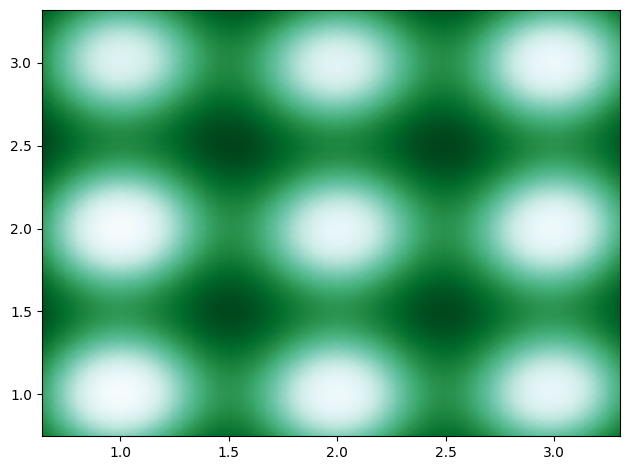

<Figure size 640x480 with 0 Axes>

In [ ]:
data = sample(1000)
plot_density(data)

## VAE on a Toy Problem

Recall that when training a VAE we're concerned with the following problem:

$$\min_{\phi} \,\ \mathbb E_{x \sim Pop, z \sim P_\phi(z|x)} \left[ \ln \frac{P_\phi(z|x)}{P(z)} - \ln P_\phi(x|z) \right] \,.$$

We'll model $P_\phi(z|x)$ with an encoder and $P_\phi(x|z)$ with a decoder as follows:
$$P_\phi(z|x) = \mathcal N \left(\mu_{\phi,z}(x), \Sigma_{\phi,z}(x) \right)$$
$$P_\phi(x|z) = \mathcal N \left( \mu_{\phi,x}(z), \sigma^2 I \right) \,,$$
where $\mu_{\phi,z}, \Sigma_{\phi,z}, \mu_{\phi,x}$ are neural networks, and $\Sigma_{\phi,z}(x)$ is diagonal.

Moreover, let $P(z)$ (the prior over $z$) to be $\mathcal N(0, I)$.


**<span style="color:blue">
    For the above distributions, what is $\ln P_\phi(x|z)$ as a function of $x, z, \mu_{\phi,x}$, and $\sigma$?
</span>**

 ------------------------------------------------------------------------------- ANSWER (BEGIN) -------------------------------------------------------------------------------

What is $\ln P_\phi(x|z)$ as a function of $x, z, \mu_{\phi,x}$, and $\sigma$?

<< My answer >>

------------------------------------------------------------------------------- ANSWER (END) -------------------------------------------------------------------------------

**<span style="color:blue">
    For the above distributions, what is $\ln \frac{P_\phi(z|x)}{P(z)}$ as a function of $x, z, \mu_{\phi,z}, \Sigma_{\phi,z}$?
</span>**


------------------------------------------------------------------------------- ANSWER (BEGIN) -------------------------------------------------------------------------------

What is $\ln \frac{P_\phi(z|x)}{P(z)}$ as a function of $x, z, \mu_{\phi,z}, \Sigma_{\phi,z}$?


------------------------------------------------------------------------------- ANSWER (END) -------------------------------------------------------------------------------

We are almost ready to set up a VAE network in PyTorch and train it. The following cell has an incomplete implementation of a VAE. The encoder and decoder networks are already defined (note that the encoder outputs $\log \Sigma$ instead of $\Sigma$, which is standard practice since otherwise we have to guarantee that the covariance matrix is non-negative). latent_dim is the dimensionality of the latent variable $z$.

Complete the implementations of encode, sample, and decode.
The encode method receives samples $x$ and has to return the mean vector $\mu_z(x)$ and the element-wise log of the diagonal of $\Sigma_z(x)$. The self.encoder network already maps $x$ to a 50-dim vector, and the self.mu, self.logvar modules can be used to map this 50-dim vector to the mean vector and the log diag of the covariance matrix.

The sample method receives mu and logvar (the outputs of encode) and has to return samples from the corresponding Gaussian distribution. Here we typically employ the reparameterization trick, where we can draw a sample $s \sim \mathcal N(\mu, \sigma)$ by doing $s = \mu + \sigma \cdot \epsilon, \epsilon \sim \mathcal N(0, 1)$, which yields well-defined gradients that autograd takes care of computing. Like in the original VAE paper, sample a single $s$ for each input.

Finally, the decode method takes $z$ as input and should return $\mu_x(z)$. You should use the self.decodet module for this.

In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Linear(2, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU()
        )

        self.mu = nn.Linear(50, latent_dim)
        self.logvar = nn.Linear(50, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 2)
        )

    def encode(self, x):
        # implementation goes here
        return mu, logvar

    def sample(self, mu, logvar):
        # implementation goes here
        return z

    def decode(self, z):
        # implementation goes here
        return out

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.sample(mu, logvar)
        out = self.decode(z)
        return mu, logvar, out

    def generate(self, n):
        z = torch.randn(n, self.latent_dim).cuda()
        samples = self.decode(z)
        return samples

Note that the previous VAE objective can be written as

$$\min_{\phi} \,\ \mathbb E_{x \sim Pop} \left[ D_{KL}(P_\phi(z|x) || P(z)) + \mathbb E_{z \sim P_\phi(z|x)} \left[ -\ln P_\phi(x|z) \right] \right] \,$$

The first term requires computation of KL divergence between two multivariate Gaussian distributions, which has a closed form solution. The second term requires sampling noise. As in the case of the original VAE paper, sample a single $z$ for every $x$ in the forward pass in order to compute this second quantity.

Now, implement the loss of the VAE by deriving the closed-form expression for the KL divergence as well as using the expression for $\ln P_\phi(x|z)$ you derived previously. The recon_loss term should have the factor corresponding to $P_\phi(x|z)$, while kld_loss should have the KL divergence term.

In your derivation $\sigma$ hopefully showed up as a weight between the two terms. Here we'll use the standard beta-VAE notation and apply a weight beta on the KL divergence term instead.

In [ ]:
def loss(x, out, mu, logvar, beta):
    recons_loss = # implementation goes here
    kld_loss = # implementation goes here
    loss = recons_loss + beta * kld_loss
    return recons_loss, kld_loss, loss

We can then train the VAE on the toy problem and see how it performs.
Try different values of beta until you find one that yields good results.

In [ ]:
vae = VAE(100).cuda()
opt = torch.optim.Adam(vae.parameters(), lr=5e-4)

In [ ]:
beta = 1.0
for i in range(20000):
    s = sample(128).cuda()
    mu, logvar, out = vae(s)
    rl, kl, l = loss(s, out, mu, logvar, beta)
    opt.zero_grad()
    l.backward()
    opt.step()
    if i % 1000 == 0:
        data = vae.generate(5000)
        plot_density(data.cpu().data)

**<span style="color:blue">
    How does beta affect the performance of the VAE? Show or discuss what tradeoff beta controls, and how this can be observed from the above plots and/or any additional plots.
</span>**

**<span style="color:red">
    ------------------------------------------------------------------------------- ANSWER (BEGIN) -------------------------------------------------------------------------------
</span>**

**<span style="color:red">
    ------------------------------------------------------------------------------- ANSWER (END) -------------------------------------------------------------------------------
</span>**

## GAN

Recall the GAN objective
$$\min_\psi \max_\phi \,\ \mathbb E_{x \sim Pop}[ -\ln P_\psi(1 | x) ] + \mathbb E_{z \sim \mathcal N(0,1)} [- \ln P_\psi(0|G_\phi(z))  ] \,,$$
where $G_\phi$ is a network that maps gaussian noise $z \sim \mathcal N(0,1)$ to $G(z)$ with the same shape as $x$, and $P_\psi$ is modeled by another network (the discriminator) that maps real samples $x$ and 'fake' samples $G(z)$ to a distribution over $\{0,1\}$.

We will follow the common practice of adopting a different objective for the generator network $G$:
$$\min_\phi \,\ \mathbb E_{z \sim \mathcal N(0,1)} [- \ln P_\psi(1|G_\phi(z))  ] \,.$$

First, complete the implementation of the Generator module below. The forward method takes an integer $n$ as input and should return $n$ samples $G(z), z \sim \mathcal N(0, I)$, each with dimensionality 2. You should use the self.network module for the mapping $G$.

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim

        self.network = nn.Sequential(
            nn.Linear(latent_dim, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 2)
        )

    def decode(self, input):
        out = self.network(input)
        return out

    def forward(self, n):
        z = # implementation goes here
        samples = # implementation goes here
        return samples

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(2, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 1)
        )

    def forward(self, input):
        out = self.network(input)
        return out

In [ ]:
generator = Generator(100).cuda()
gopt = torch.optim.Adam(generator.parameters(), lr=5e-4, betas=(0.5, 0.999))
discriminator = Discriminator().cuda()
dopt = torch.optim.Adam(discriminator.parameters(), lr=5e-4, betas=(0.5, 0.999))
criterion = torch.nn.BCEWithLogitsLoss()

Now, you'll implement the training procedure for GANs. In each iteration of the for loop below we'll update the parameters of the generator and then update the discriminator.

Fill up the missing code below. You should rely on the objective given previously to define the loss of the generator and the discriminator (both the function, the data inputs, and the target labels).

In [ ]:
for i in range(20000):
    # Train G

    # implementation goes here



    # Train D

    # implementation goes here

    if i % 1000 == 0:
        data = generator(5000)
        plot_density(data.cpu().data)

**<span style="color:blue">
    Compare and discuss the results you obtained with the VAE and with the GAN approach.
</span>**

**<span style="color:red">
    ------------------------------------------------------------------------------- ANSWER (BEGIN) -------------------------------------------------------------------------------
</span>**

**<span style="color:red">
    ------------------------------------------------------------------------------- ANSWER (END) -------------------------------------------------------------------------------
</span>**

## VAE and GANs on CelebA/MNIST

In this second part of the assignment you'll train a VAE and a GAN on a more interesting dataset. The cell below will try to download and load CelebA, and will just load MNIST in case there is an error.

It is likely that you'll get an error when trying to download CelebA since the its google drive is always out of quota. If you'd like to use CelebA anyway, you can try to download it from here http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html or some other source. If you're not running this notebook on a GPU then use MNIST instead.

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize(64), transforms.CenterCrop(64), transforms.Normalize((0.5,), (0.5,))])
try:
    dataset = datasets.CelebA("data", split='all', download=True, transform=transform)
except:
    dataset = datasets.MNIST("data", train=True, download=True, transform=transform)
loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

We'll use a a CNN for the VAE instead of the simple model we defined previously.
Implement a network following these specifications:

- Encoder. Should have 4 conv layers, each with kernel size 4, stride 2 and padding 1, which decrease the spatial resolution by half. The output of the 4th conv (a spatial res. 4x4) should be flattened and then fully connected layers should be used to compute mu and logvar. Add whichever activation function you prefer between the conv layers (ReLU, LeakyReLU, ELU, etc), and feel free to add batch norm as well. Let the first conv layer have, say, 8 or 16 channels and then double the number of channels at each following conv layer.

- Decoder. Try to have an architecture that is roughly symmetric to the encoder. For example, start with a fully connected layer to project the latent_dim dimensional input such that you end up wuth a (128*4*4)-dimensional vector that you can reshape into a 4x4 image. Then you can apply 4 transposed conv layers, e.g. with kernel size 4, stride 2 and padding 1, to double the spatial resolution with each layer, having a final output of size 64x64. Start with around 64 or 128 channels for the first transposed conv and then halve the number of channels at each following conv layer. As before, add your preferred activation function between layers, with or without batch norm.

The encode, sample, and decode methods have the same specification as before.

In [ ]:
class ConvVAE(nn.Module):
    def __init__(self, latent_dim):
        super(ConvVAE, self).__init__()
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            # implementation goes here
        )

        self.decoder = nn.Sequential(
            # implementation goes here
        )

    def encode(self, input):
        # implementation goes here
        return mu, logvar

    def sample(self, mu, logvar):
        # implementation goes here
        return eps * std + mu

    def decode(self, input):
        # implementation goes here
        return out

    def forward(self, input):
        mu, logvar = self.encode(input)
        z = self.sample(mu, logvar)
        out = self.decode(z)
        return mu, logvar, out

    def generate(self, n):
        z = torch.randn(n, self.latent_dim).cuda()
        samples = self.decode(z)
        return samples

In [ ]:
vae = ConvVAE(100).cuda()
opt = torch.optim.Adam(vae.parameters(), lr=5e-4)

The cell below applies a 'patch' in case you're using google colab (cv2_imshow doesn't work properly on google colab without it). Feel free to comment out the first import if you're not using google colab (you might have to add from cv2 import cv2_imshow, though).

In [ ]:
from google.colab.patches import cv2_imshow
import cv2

def show(x):
    img = x.data.cpu().permute(1, 2, 0).numpy() * 255
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2_imshow(img)

Again, try to find a value for beta that yields reasonable results.

In [ ]:
beta = 1.0
for epoch in range(100):
    for i, x in enumerate(loader):
        if len(x) == 2:
            x = x[0]
        x = x.cuda()

        mu, logvar, out = vae(x)
        rl, kl, l = loss(x, out, mu, logvar, beta)

        opt.zero_grad()
        l.backward()
        opt.step()
        if i == 0:
            vae.eval()
            data = vae.generate(8)
            grid_img = torchvision.utils.make_grid(data, nrow=8, normalize=True)
            show(grid_img)
            vae.train()

You'll also re-implement the Generator and Discriminator modules for the GAN, adopting a CNN-like architecture.

For the generator, implement a network similar to the one you used for the VAE decoder (fully connected for projection followed by 4 transposed convolutions), while for the discriminator you should use a network similar to the VAE encoder (4 conv layers with stride 2, but note that the output should be a scalar per image, not a latent vector).

In [ ]:
class ConvGenerator(nn.Module):
    def __init__(self, latent_dim):
        super(ConvGenerator, self).__init__()
        self.latent_dim = latent_dim

        self.network = nn.Sequential(
            # implementation goes here
        )

    def decode(self, input):
        out = # implementation goes here
        return out

    def forward(self, n):
        z = torch.randn(n, self.latent_dim).cuda()
        samples = self.decode(z)
        return samples

In [ ]:
class ConvDiscriminator(nn.Module):
    def __init__(self, latent_dim):
        super(ConvDiscriminator, self).__init__()

        self.network = nn.Sequential(
            # implementation goes here
        )

    def forward(self, input):
        out = # implementation goes here
        return out

In [ ]:
generator = ConvGenerator(100).cuda()
gopt = torch.optim.Adam(generator.parameters(), lr=5e-4, betas=(0.5, 0.999))
discriminator = ConvDiscriminator(100).cuda()
dopt = torch.optim.Adam(discriminator.parameters(), lr=5e-4, betas=(0.5, 0.999))
criterion = torch.nn.BCEWithLogitsLoss()

In [ ]:
for epoch in range(100):
    for i, x in enumerate(loader):
        if len(x) == 2:
            x = x[0]
        x = x.cuda()

        # Train G

        # implementation goes here


        # Train D

        # implementation goes here

        if i == 0:
            grid_img = torchvision.utils.make_grid(fake[:8], nrow=8, normalize=True)
            show(grid_img)

**<span style="color:blue">
    Compare and discuss the results you obtained with the VAE and with the GAN approach for this new dataset. Which of the two approaches was able to generate more realistic samples? Which of the two did you feel that you understood better (there is no correct answer here), and why? Mention one advantage and disadvantage of each of the two methods -- these should be precise properties about each approach, with a focus on what each method can and cannot do. Feel free to check papers, the original GAN paper might be especially helpful.
</span>**

**<span style="color:red">
    ------------------------------------------------------------------------------- ANSWER (BEGIN) -------------------------------------------------------------------------------
</span>**

**<span style="color:red">
    ------------------------------------------------------------------------------- ANSWER (END) -------------------------------------------------------------------------------
</span>**